In [1]:
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool, PythonAstREPLTool
import pandas as pd
import statsmodels as sm

df = pd.read_csv("HOUST.csv")
python_repl_tool = PythonAstREPLTool(locals={"df": df})

In [2]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
import functools

system_prompt = """You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
                It is important to understand the attributes of the dataframe before working with it. This is the result of running `df.head().to_markdown()`

                <df>
                {dhead}
                </df>

                You are not meant to use only these rows to answer questions - they are meant as a way of telling you about the shape and schema of the dataframe. 
                You also do not have use only the information here to answer questions - you can run intermediate queries to do exporatory data analysis to give you more information as needed. """
system_prompt = system_prompt.format(dhead=df.head().to_markdown())

# part of the problem might be that I'm passing a PromptTemplate object for the system_prompt here
# not everything needs to be an openai tools agent
def create_agent(llm: ChatOpenAI, tools: list, task: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            ( "system", system_prompt, ), # using a global system_prompt
            HumanMessage(content=task),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

# AIMessage will have all kinds of metadata, so treat it all as HumanMessage I suppose?
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

# I need to write the message to state here? or is that handled automatically?
def chain_node(state, chain, name):
    result = chain.invoke(input={"detail": "medium"})
    return {"messages": [HumanMessage(content=result.content, name=name)]}

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0)

eda_task = "Determine if the data is stationary by running an augmented dickey fuller test."
eda_agent = create_agent(llm, [python_repl_tool], task=eda_task,)
eda_node = functools.partial(agent_node, agent=eda_agent, name="EDA")

# add an optional differencing node

In [4]:
acf_task =  """Using the data in the dataframe `df` and the package statsmodels.
            First generate an ACF plot with zero flag set to False, display it and save it to 'acf.png'.
            Then generate a PACF plot with zero flag set to False, display it and save it to 'pacf.png'"""

# ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
acf_agent = create_agent(llm, [python_repl_tool], task=acf_task,)
acf_node = functools.partial(agent_node, agent=acf_agent, name="ACF")

In [5]:
plot_template = ChatPromptTemplate.from_messages(
    messages=[
        SystemMessage(content='The two plots contain the autocorrelation and partial autocorrelation functions for a time series, based on these plots up to what order AR and MA terms should be considered when estimating an ARMA model for this time series?'),
        HumanMessagePromptTemplate.from_template(
            template=[{"type": "image_url", "image_url": {"path": "acf.png"}},
                      {"type": "image_url", "image_url": {"path": "pacf.png"}}]),
    ]
)

plot_chain = plot_template | llm
plot_node = functools.partial(chain_node, chain=plot_chain, name="PlotAnalysis")

In [6]:
arima_task = """Using the data in the dataframe `df` and the package statsmodels. 
    Estimate an ARIMA model with the appropriate AR and MA terms and display the estimated model.
    Then generate an autocorrelation and partial autocorrelation plot of the model residuals with zero flag set to False, display it and save it as 'resid_acf.png'"""

# Finally generate a partial autocorrelation plot of the model residuals with zero flag set to False, display it and save it as 'resid_pacf.png'

arima_agent = create_agent(llm, [python_repl_tool], task=arima_task,)
arima_node = functools.partial(agent_node, agent=arima_agent, name="ARIMA")

In [7]:
# do the same analyzing the model output
resid_template = ChatPromptTemplate.from_messages(
    messages=[
        SystemMessage(content="""The two plots contain the residuals autocorrelation and partial autocorrelations of an ARIMA model.
                      Based on the plots are any of the autocorrelations significant?
                      Should additional AR or MA terms be included in the model?"""),
        HumanMessagePromptTemplate.from_template(
            template=[{"type": "image_url", "image_url": {"path": "resid_acf.png"}},
                      {"type": "image_url", "image_url": {"path": "resid_pacf.png"}}]),
    ]
)

# maybe add system role etc
oresid_template = ChatPromptTemplate.from_messages(
    messages=[
        SystemMessage(content="""The plot contains the autocorrelation and partial autocorrelation of residuals from an ARIMA model.
                      Based on the plot are any of the residual autocorrelations significant?
                      Should additional AR or MA terms be included in the model?"""),
        HumanMessagePromptTemplate.from_template(
            template=[{"type": "image_url", "image_url": {"path": "resid_acf.png"}}]),
    ]
)

resid_chain = oresid_template | llm
resid_node = functools.partial(chain_node, chain=resid_chain, name="Resid")

In [8]:
from langgraph.graph import END, StateGraph, START
import operator
from typing import Sequence, TypedDict

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# add a chain to the node to analyze the ACF plot?
workflow = StateGraph(AgentState)
workflow.add_node("EDA", eda_node)
workflow.add_node("ACF", acf_node)
workflow.add_node("PlotAnalysis", plot_node)
workflow.add_node("ARIMA", arima_node)
workflow.add_node("Resid", resid_node)

workflow.add_edge(START, "EDA")
workflow.add_edge("EDA", "ACF")
workflow.add_edge("ACF", "PlotAnalysis")
workflow.add_edge("PlotAnalysis", "ARIMA")
workflow.add_edge("ARIMA", "Resid")
workflow.add_edge("Resid", END)

graph = workflow.compile()

<Figure size 1000x500 with 0 Axes>

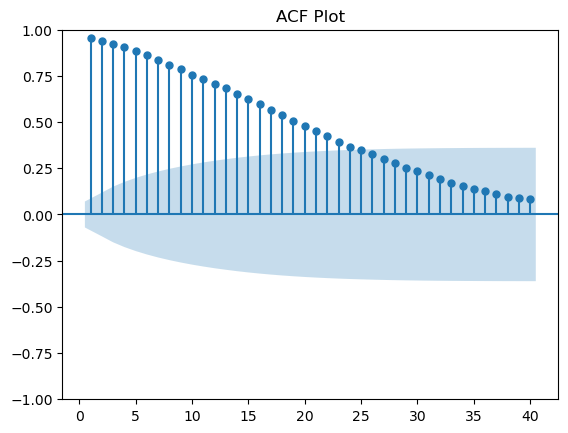

<Figure size 1000x500 with 0 Axes>

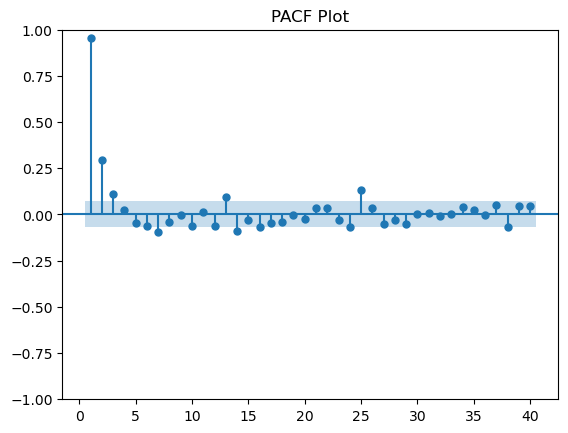

c:\Users\paulw\Anaconda3\envs\autobox\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\paulw\Anaconda3\envs\autobox\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\paulw\Anaconda3\envs\autobox\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  HOUST   No. Observations:                  777
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4783.272
Date:                Thu, 05 Sep 2024   AIC                           9572.544
Time:                        18:04:37   BIC                           9586.510
Sample:                    01-01-1959   HQIC                          9577.916
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1433.0966     91.611     15.643      0.000    1253.543    1612.651
ar.L1          0.9538      0.011     85.412      0.000       0.932       0.976
sigma2      1.299e+04    526.830     24.658      0.0

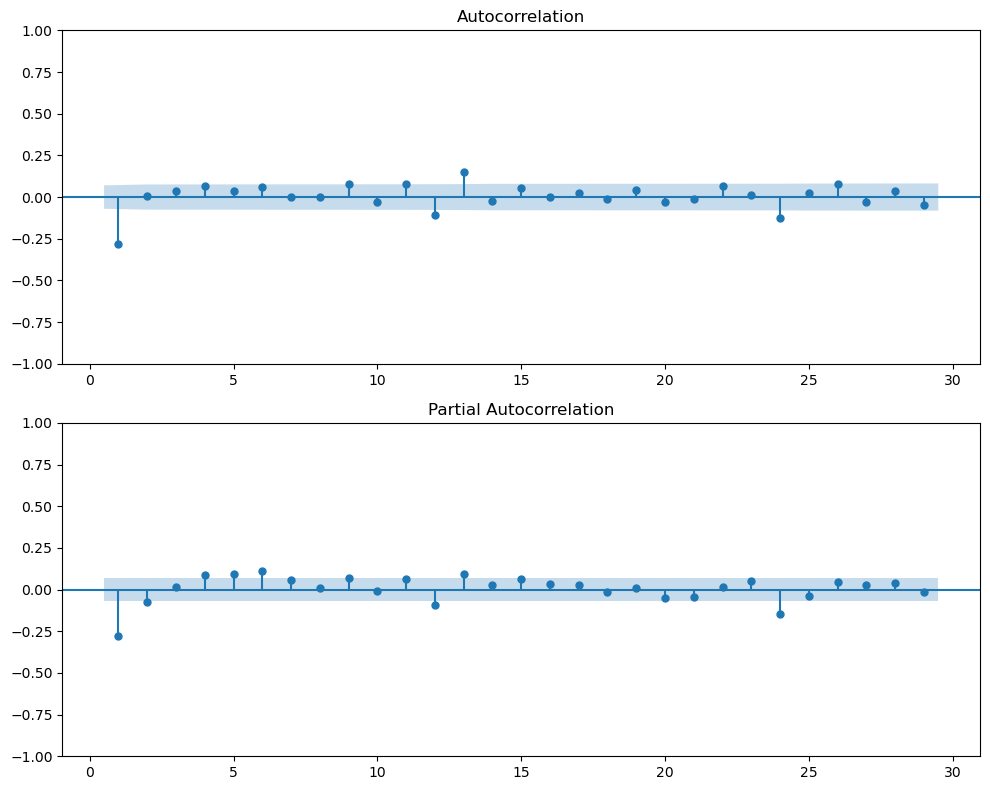

{'messages': [HumanMessage(content='Run the analysis'),
  HumanMessage(content='The results of the Augmented Dickey-Fuller test are as follows:\n\n- Test Statistic: -3.7981\n- p-value: 0.0029\n- Number of Lags: 15\n- Number of Observations: 761\n- Critical Values:\n  - 1%: -3.4390\n  - 5%: -2.8653\n  - 10%: -2.5688\n\n### Interpretation:\n- The null hypothesis of the Augmented Dickey-Fuller test is that the time series has a unit root, meaning it is non-stationary.\n- Since the p-value (0.0029) is less than the common significance levels (0.01, 0.05, and 0.10), we reject the null hypothesis.\n- Additionally, the test statistic (-3.7981) is less than the critical value at the 1% level (-3.4390), which further supports the conclusion.\n\n### Conclusion:\nThe data appears to be stationary.', name='EDA'),
  HumanMessage(content="The ACF and PACF plots have been generated, displayed, and saved as 'acf.png' and 'pacf.png', respectively. If you need any further analysis or assistance, feel fr

In [9]:
graph.invoke({"messages": [HumanMessage(content="Run the analysis")]})